In [92]:
%matplotlib inline

In [93]:
import os,sys
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm as pcm
import shapely
import logging
import pandas
import copy
pandas.options.display.max_columns = None


import watershed_workflow
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.colors
import watershed_workflow.condition
import watershed_workflow.mesh
import watershed_workflow.split_hucs
import watershed_workflow.create_river_mesh
import watershed_workflow.densify_rivers_hucs

watershed_workflow.ui.setup_logging(1,None)
figsize = (6,6)
figsize_3d = (8,6)

# Read the watershed boundaries

In [94]:
hucs = ['060102070302'] # This is the huc for East Fork Poplar Creek

# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = watershed_workflow.source_list.dem_sources['NED 1/3 arc-second']
watershed_workflow.source_list.log_sources(sources)
crs = watershed_workflow.crs.daymet_crs() # Use the same projection than Daymet

_, ws = watershed_workflow.get_huc(sources['HUC'], hucs[0], crs)

my_hucs = []
for huc in hucs:
    _, ws = watershed_workflow.get_huc(sources['HUC'], huc, crs)
    my_hucs.append(ws)
    
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)


2022-09-22 14:52:06,917 - root - INFO: Using sources:
2022-09-22 14:52:06,918 - root - INFO: --------------
2022-09-22 14:52:06,919 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2022-09-22 14:52:06,922 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2022-09-22 14:52:06,923 - root - INFO: DEM: National Elevation Dataset (NED)
2022-09-22 14:52:06,924 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2022-09-22 14:52:06,924 - root - INFO: geologic structure: GLHYMPS version 2.0
2022-09-22 14:52:06,924 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2022-09-22 14:52:06,925 - root - INFO: soil thickness: None
2022-09-22 14:52:06,925 - root - INFO: meteorology: DayMet 1km
2022-09-22 14:52:06,926 - root - INFO: 
2022-09-22 14:52:06,926 - root - INFO: Loading HUC 060102070302
2022-09-22 14:52:06,927 - root - INFO: ---------

# Read the river reaches

In [95]:
include_rivers=True
ignore_small_rivers = False
prune_by_area_fraction = False

if include_rivers:
    # download/collect the river network within that shape's bounds    
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], huc, 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True, 
                                                include_catchments=True)
    
    rivers = watershed_workflow.construct_rivers(watershed, reaches, method='hydroseq',
                                                ignore_small_rivers=ignore_small_rivers,
                                                prune_by_area_fraction=prune_by_area_fraction,
                                                remove_diversions=True,
                                                remove_braided_divergences=True)

2022-09-22 14:52:10,654 - root - INFO: 
2022-09-22 14:52:10,658 - root - INFO: Loading Hydrography
2022-09-22 14:52:10,660 - root - INFO: ------------------------------
2022-09-22 14:52:10,661 - root - INFO: Loading streams in HUC 060102070302
2022-09-22 14:52:10,662 - root - INFO:          and/or bounds (1345772.6458075882, -571056.2786547501, 1358722.0666446937, -558489.114717032)
2022-09-22 14:52:10,664 - root - INFO:   Using Hydrography file "/Users/8n8/Documents/data_research/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb"
2022-09-22 14:52:10,665 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/8n8/Documents/data_research/hydrography/NHDPlus_H_0601_GDB/NHDPlus_H_0601.gdb' layer 'NHDFlowline' for streams in '(1345772.6458075882, -571056.2786547501, 1358722.0666446937, -558489.114717032)'
2022-09-22 14:52:11,826 - root - INFO:   Found total of 984 in bounds.
2022-09-22 14:52:11,826 - root - INFO:   Filtering reaches not in-network
2

In [96]:
# Identify the main river

da_km2_rivers = []
for rr in rivers:
    da_km2_rivers.append(rr.properties['TotalDrainageAreaSqKm'])
da_km2_rivers = np.array(da_km2_rivers)
idx_largest = da_km2_rivers.argmax()

river = rivers[idx_largest]


/Users/8n8/opt/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


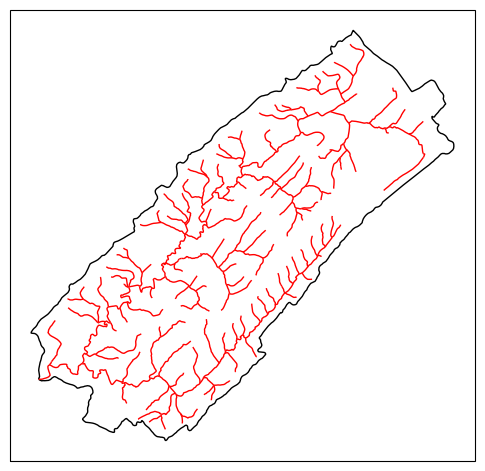

In [97]:
fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs,fig)
watershed_workflow.plot.hucs(watershed, crs, ax=ax, color='k', linewidth=1)
watershed_workflow.plot.rivers(river, crs, ax=ax, color='red', linewidth=1)
plt.show()

## Estimate the width function

In [98]:
n_nodes = len(river)
d_to_outlet_m = []

for node in river.preOrder(): # Move    
    length_to_outlet=0
    for node_on_path in node.pathToRoot():
        length_to_outlet +=  node_on_path.segment.length
    d_to_outlet_m.append(length_to_outlet)
    node.properties['lenth to outlet']=length_to_outlet
    
d_to_outlet_m = np.array(d_to_outlet_m)

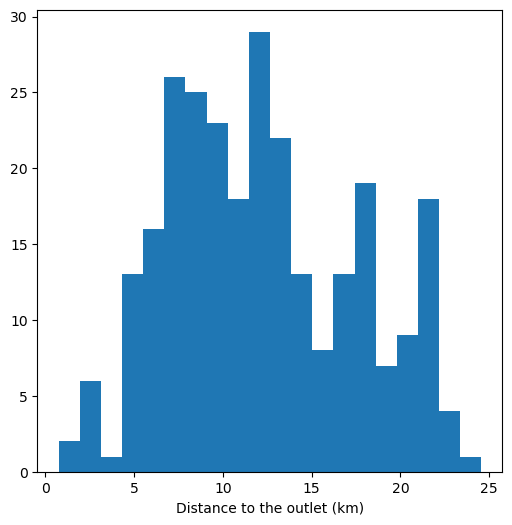

In [99]:
fig = plt.figure(figsize=figsize)
plt.hist(d_to_outlet_m/1000,20)
plt.xlabel('Distance to the outlet (km)')
plt.show()

# Refine the river network

In [100]:
rivers_orig = [rr.deep_copy() for rr in rivers] # mimicking the original
watershed_orig = copy.deepcopy(watershed) # keeping the original

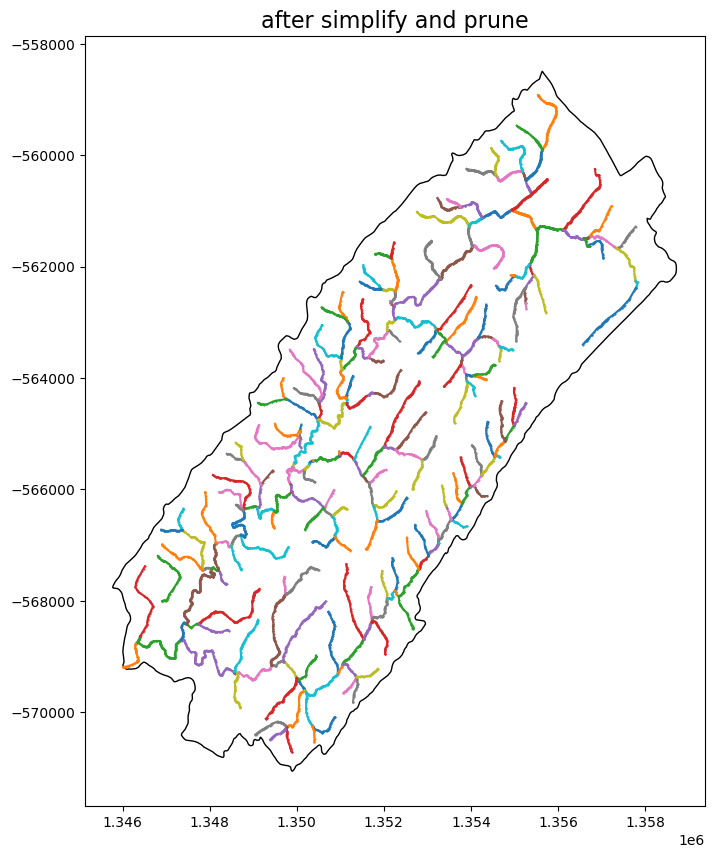

In [101]:
# quick glance at the problem
plt.rcParams['figure.figsize'] = [8, 10]

fig, axs = plt.subplots(1,1)

watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs)
axs.set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs.plot(x,y,'-o',markersize=.5)

In [102]:
# simplify the geometry for a "nicer" discrete object
watershed_workflow.simplify(watershed, rivers, simplify_rivers=10,
                            snap=False, cut_intersections=True)

# processing originals to match structure of river tree as simplified while keeping the high resolution
watershed_workflow.simplify(watershed_orig, rivers_orig, simplify_rivers=0.1,
                            snap=False, cut_intersections=True)

# for plotting purpose
rivers_simplified=[rr.deep_copy() for rr in rivers] 
river_simplified = rivers_simplified[idx_largest]
watershed_simplified=copy.deepcopy(watershed) 

2022-09-22 14:53:47,896 - root - INFO: 
2022-09-22 14:53:47,904 - root - INFO: Simplifying
2022-09-22 14:53:47,906 - root - INFO: ------------------------------
2022-09-22 14:53:47,907 - root - INFO: Simplifying rivers
2022-09-22 14:53:47,930 - root - INFO:   ...cleaned inner segment of length 6.38544 at centroid (1347343.0460752062, -568698.1538890129)
2022-09-22 14:53:47,932 - root - INFO:   ...cleaned inner segment of length 7.39894 at centroid (1347464.6876121894, -568412.6902916784)
2022-09-22 14:53:47,932 - root - INFO:   ...cleaned inner segment of length 6.90729 at centroid (1348037.9182263156, -567422.977953578)
2022-09-22 14:53:47,933 - root - INFO:   ...cleaned inner segment of length 8.47343 at centroid (1348713.7410946952, -566816.2858125137)
2022-09-22 14:53:47,934 - root - INFO:   ...cleaned inner segment of length 7.02154 at centroid (1349095.2200573036, -566331.6674489698)
2022-09-22 14:53:47,935 - root - INFO:   ...cleaned inner segment of length 7.12489 at centroid (

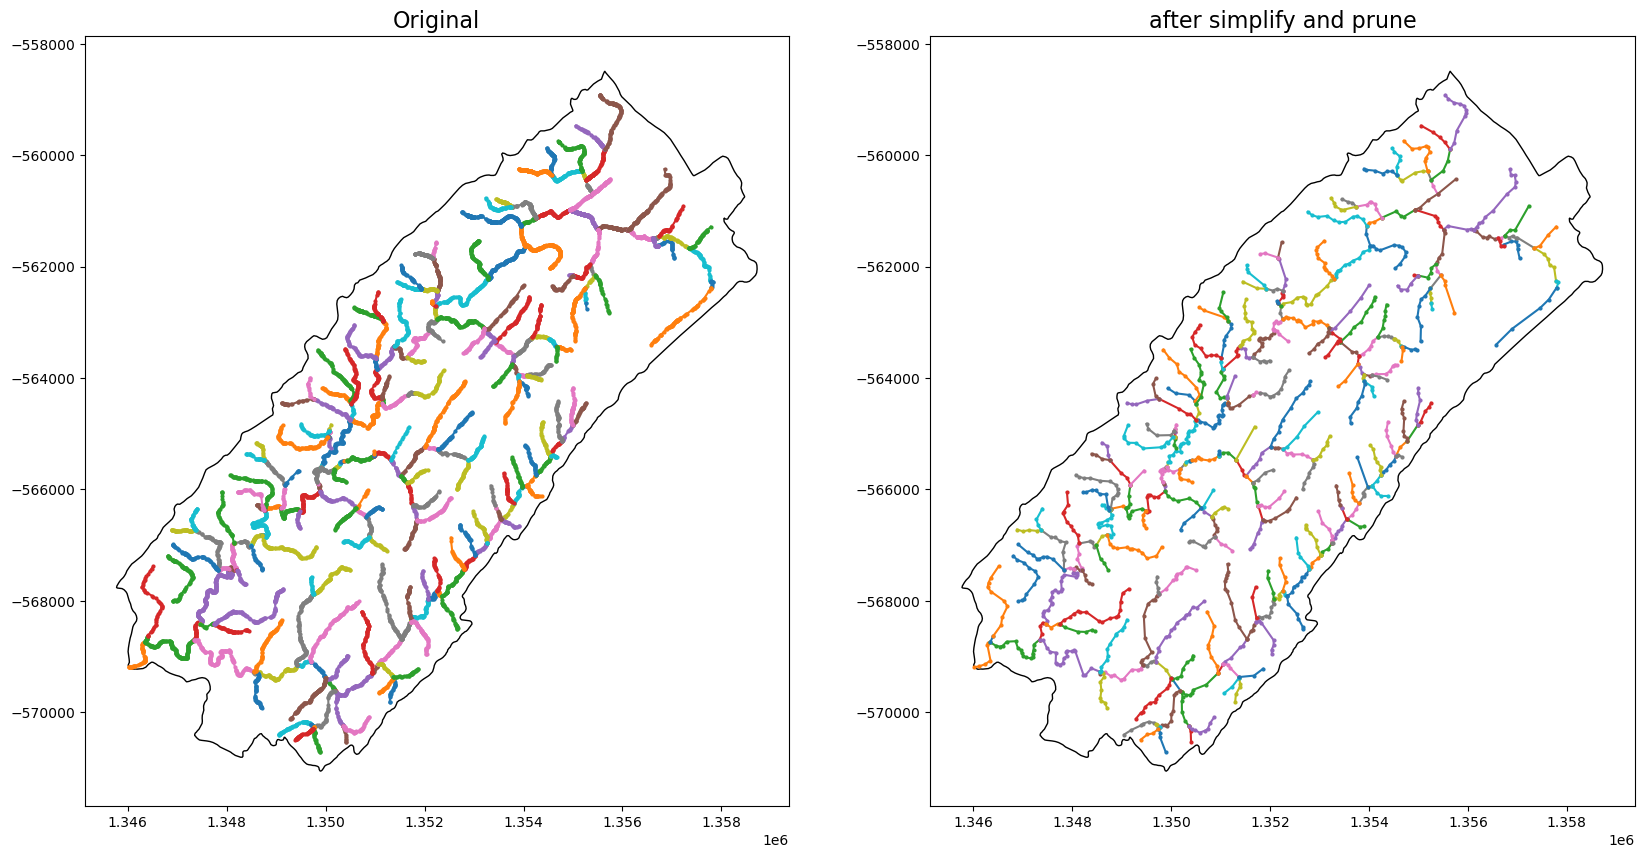

In [103]:
# quick glance at the problem

fig, axs = plt.subplots(1,2,figsize=[20,10])

watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0])
axs[0].set_title('Original',fontsize=16)
for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)
    
    
watershed_workflow.plot.hucs(watershed_simplified, crs, 'k', axs[1])
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)

In [106]:
#densify watershed
watershed_dens=watershed_workflow.densify_rivers_hucs.densify_hucs(watershed, watershed_orig, rivers, use_original= False,limit_scales=[0,25,100,50])

#densify river
rivers_dens=watershed_workflow.densify_rivers_hucs.densify_rivers(rivers, rivers, limit=30, use_original=False, treat_collinearity=True)

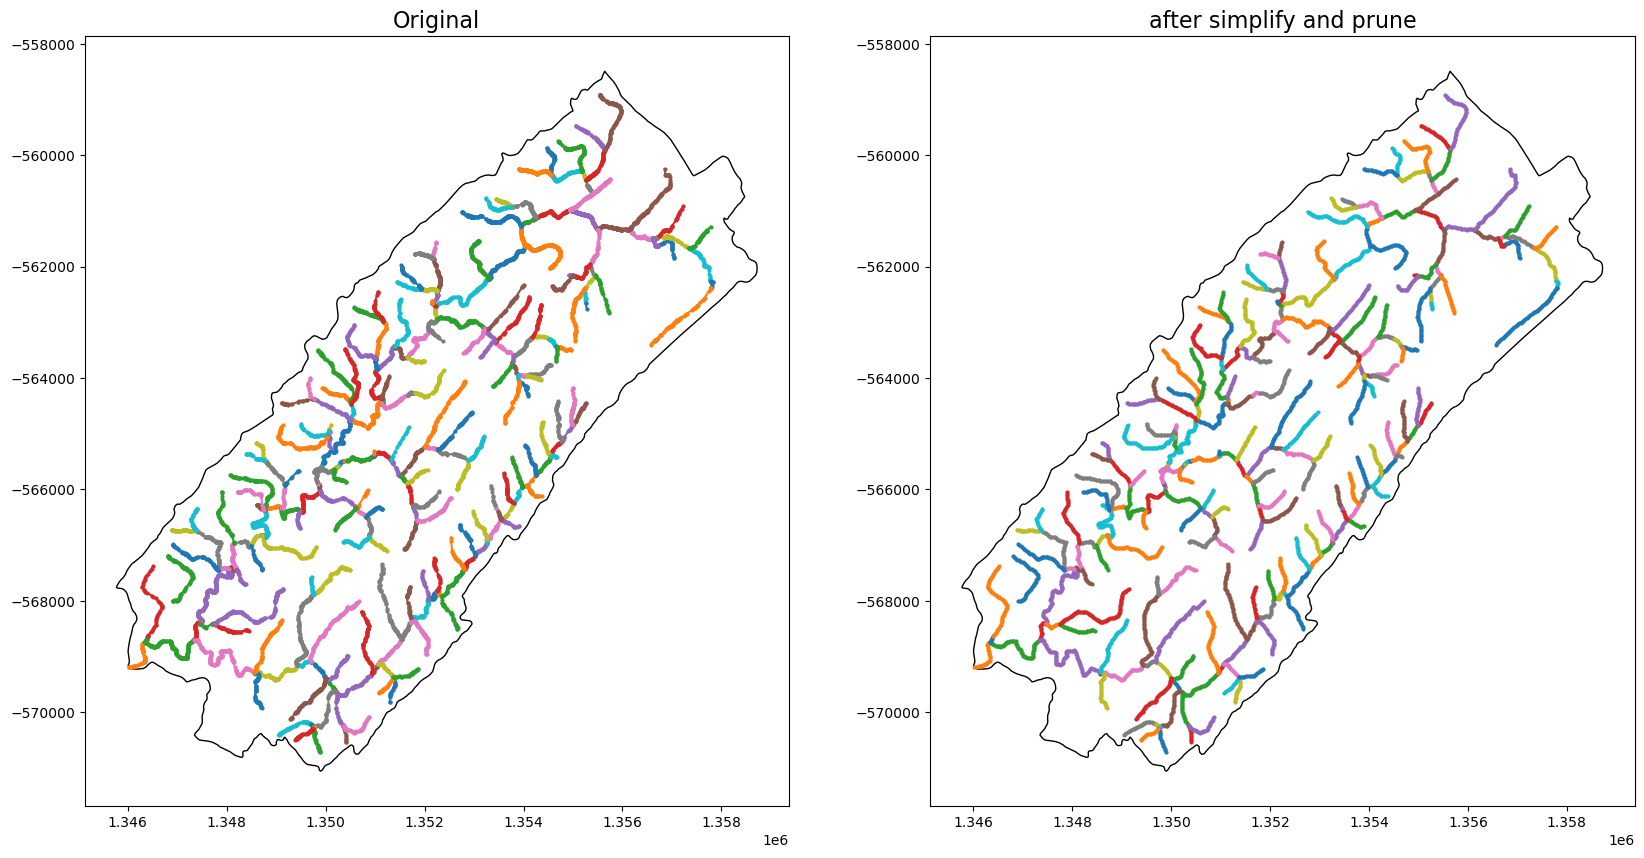

In [107]:
# quick glance at the problem

fig, axs = plt.subplots(1,2,figsize=[20,10])

watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0])
axs[0].set_title('Original',fontsize=16)
for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)
    
    
watershed_workflow.plot.hucs(watershed_dens, crs, 'k', axs[1])
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_dens:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)

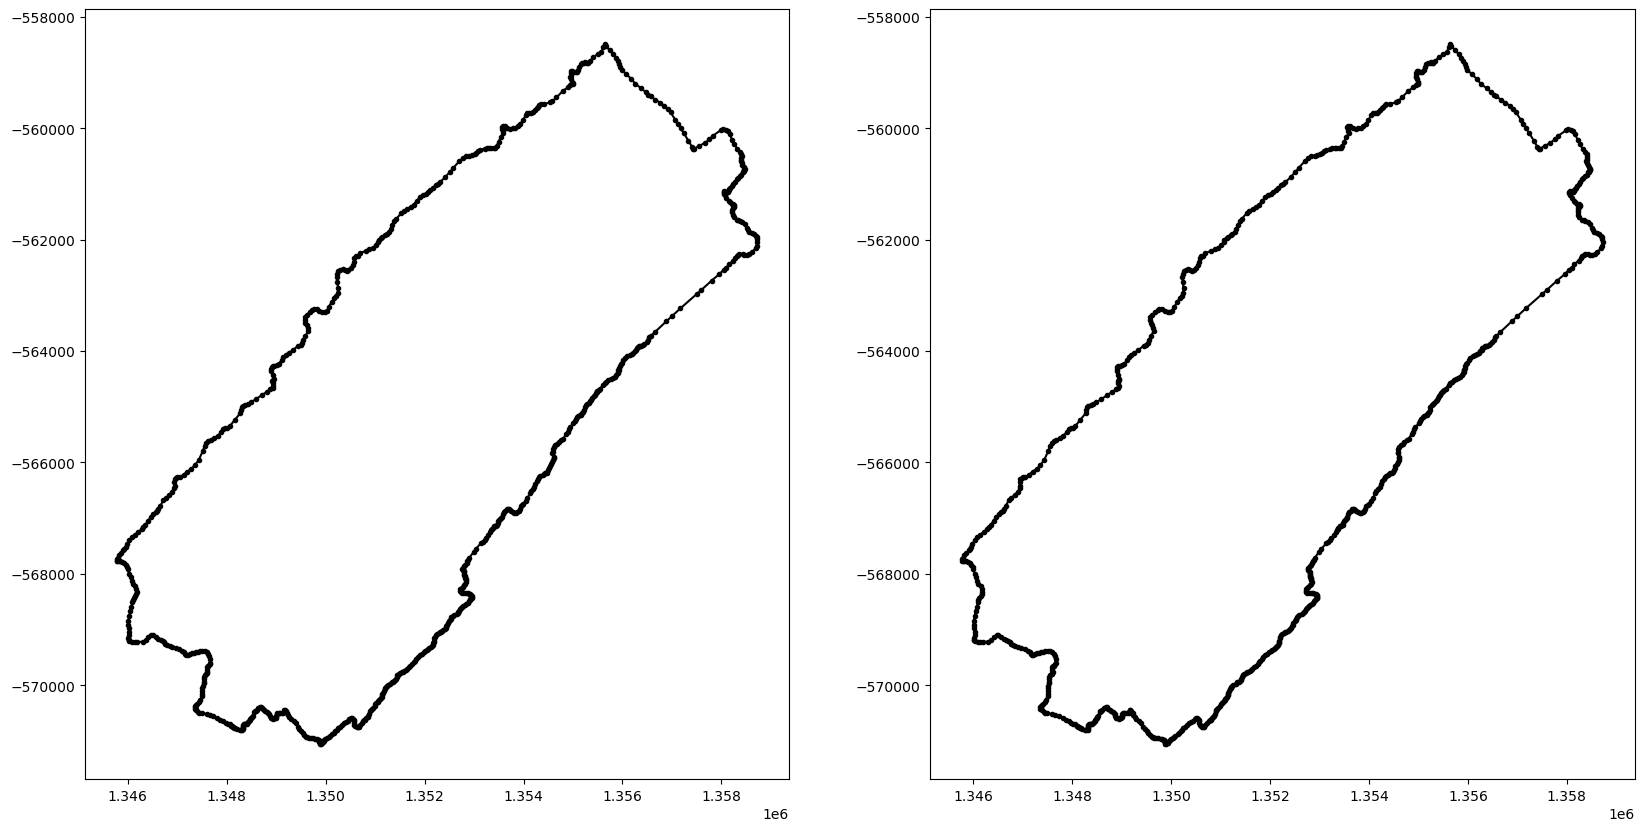

In [79]:
fig, axs = plt.subplots(1,2,figsize=[20,10])
axs[0].plot(watershed_orig.exterior().exterior.xy[0], watershed_orig.exterior().exterior.xy[1], 'k.-')
axs[1].plot(watershed_simplified.exterior().exterior.xy[0], watershed_simplified.exterior().exterior.xy[1], 'k.-')

In [113]:
n_nodes = len(river)
d_to_outlet_m = []

main_river = rivers_dens[1]

for node in main_river.preOrder(): # Move    
    length_to_outlet=0
    for node_on_path in node.pathToRoot():
        length_to_outlet +=  node_on_path.segment.length
    d_to_outlet_m.append(length_to_outlet)
    node.properties['lenth to outlet']=length_to_outlet
    
d_to_outlet_m = np.array(d_to_outlet_m)

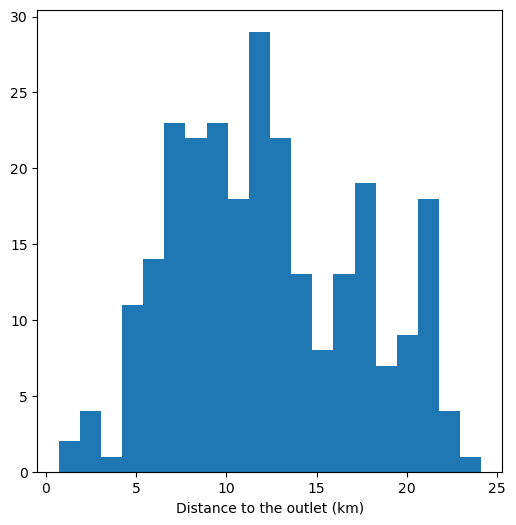

In [114]:
fig = plt.figure(figsize=figsize)
plt.hist(d_to_outlet_m/1000,20)
plt.xlabel('Distance to the outlet (km)')
plt.show()